**Sample Dataset Generation for Weather-Electricity Analysis which replicates the actual data structure**

In [51]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

np.random.seed(42)

start_date = '2019-01-01'
end_date = '2024-04-30'
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
def generate_temperature_data(month):
    """Generate realistic temperature data for Telangana based on month"""
    base_temps = {
        1: 22, 2: 25, 3: 28, 4: 32, 5: 35,  # Jan-May
        6: 30, 7: 27, 8: 26, 9: 27, 10: 26,  # Jun-Oct
        11: 23, 12: 21  # Nov-Dec
    }

    base_temp = base_temps[month]

    avg_temp = base_temp + np.random.normal(0, 1.5)
    max_temp = avg_temp + np.random.uniform(5, 8)
    min_temp = avg_temp - np.random.uniform(5, 8)

    return round(avg_temp, 1), round(max_temp, 1), round(min_temp, 1)

def generate_humidity_data(month, rainfall):
    """Generate humidity data based on month and rainfall"""
    # Base humidity by month
    base_humidity = {
        1: 55, 2: 50, 3: 45, 4: 40, 5: 35,
        6: 65, 7: 75, 8: 80, 9: 75, 10: 70,
        11: 60, 12: 58
    }

    humidity = base_humidity[month] + (rainfall / 10) + np.random.normal(0, 5)
    return round(np.clip(humidity, 30, 95), 1)

def generate_rainfall_data(month):
    """Generate rainfall data based on month"""
    rainfall_patterns = {
        1: 5, 2: 8, 3: 15, 4: 25, 5: 40,
        6: 120, 7: 180, 8: 170, 9: 150, 10: 80,
        11: 25, 12: 10
    }
    base_rainfall = rainfall_patterns[month]
    rainfall = max(0, base_rainfall + np.random.normal(0, base_rainfall * 0.3))
    return round(rainfall, 1)

def generate_electricity_consumption(temp, humidity, month, year):
    """Generate electricity consumption based on weather parameters"""
    year_factor = 1 + (year - 2019) * 0.05

    # Seasonal base consumption (MU - Million Units)
    base_consumption = 4500 * year_factor
    temp_effect = 0
    if temp > 25:
        temp_effect = (temp - 25) * 50
    humidity_effect = 0
    if humidity > 60 and temp > 25:
        humidity_effect = (humidity - 60) * 5
    monthly_factors = {
        1: 0.9, 2: 0.95, 3: 1.05, 4: 1.15, 5: 1.25,
        6: 1.1, 7: 1.0, 8: 0.95, 9: 0.95, 10: 0.9,
        11: 0.85, 12: 0.88
    }
    consumption = (base_consumption + temp_effect + humidity_effect) * monthly_factors[month]
    consumption += np.random.normal(0, 100)
    peak_demand = consumption * 1.8 + np.random.normal(0, 50)
    return round(consumption, 0), round(peak_demand, 0)

print("Generating sample datasets...")

# Weather Data
weather_data = []
for date in date_range:
    year = date.year
    month = date.month

    avg_temp, max_temp, min_temp = generate_temperature_data(month)
    rainfall = generate_rainfall_data(month)
    humidity = generate_humidity_data(month, rainfall)

    weather_data.append({
        'Year': year,
        'Month': month,
        'Date': date,
        'Avg_Temperature_C': avg_temp,
        'Max_Temperature_C': max_temp,
        'Min_Temperature_C': min_temp,
        'Humidity_Percent': humidity,
        'Rainfall_mm': rainfall,
        'Wind_Speed_kmh': round(np.random.uniform(5, 25), 1),
        'Solar_Radiation_MJ_m2': round(15 + 10 * np.sin((month - 3) * np.pi / 6) + np.random.normal(0, 2), 1)
    })

weather_df = pd.DataFrame(weather_data)

# Electricity Consumption Data
electricity_data = []
for idx, row in weather_df.iterrows():
    consumption, peak_demand = generate_electricity_consumption(
        row['Avg_Temperature_C'],
        row['Humidity_Percent'],
        row['Month'],
        row['Year']
    )

    energy_available = consumption - np.random.uniform(0, 50)
    peak_met = peak_demand - np.random.uniform(0, 100)

    electricity_data.append({
        'Year': row['Year'],
        'Month': row['Month'],
        'Date': row['Date'],
        'State': 'Telangana',
        'Energy_Requirement_MU': consumption,
        'Energy_Available_MU': round(energy_available, 0),
        'Surplus_Deficit_MU': round(energy_available - consumption, 0),
        'Peak_Demand_MW': peak_demand,
        'Peak_Met_MW': round(peak_met, 0)
    })

electricity_df = pd.DataFrame(electricity_data)

# Combined dataset
combined_df = pd.merge(
    electricity_df[['Year', 'Month', 'Date', 'Energy_Requirement_MU', 'Energy_Available_MU',
                   'Peak_Demand_MW', 'Peak_Met_MW']],
    weather_df[['Year', 'Month', 'Avg_Temperature_C', 'Max_Temperature_C', 'Min_Temperature_C',
               'Humidity_Percent', 'Rainfall_mm', 'Wind_Speed_kmh', 'Solar_Radiation_MJ_m2']],
    on=['Year', 'Month']
)

# Added computed features
combined_df['Cooling_Degree_Days'] = combined_df['Avg_Temperature_C'].apply(
    lambda x: max(0, x - 22)
)
combined_df['Heat_Index'] = combined_df.apply(
    lambda row: row['Avg_Temperature_C'] + 0.5 * (row['Humidity_Percent'] - 50)
    if row['Humidity_Percent'] > 50 else row['Avg_Temperature_C'], axis=1
)

os.makedirs('sample_data', exist_ok=True)

print("\nSaving datasets...")
weather_df.to_csv('sample_data/telangana_weather_data_2019_2024.csv', index=False)
electricity_df.to_csv('sample_data/telangana_electricity_data_2019_2024.csv', index=False)
combined_df.to_csv('sample_data/telangana_combined_data_2019_2024.csv', index=False)

# Display sample statistics
print("\n=== Dataset Statistics ===")
print(f"\nTotal records: {len(combined_df)}")
print(f"Date range: {combined_df['Date'].min()} to {combined_df['Date'].max()}")

print("\n--- Electricity Consumption Statistics ---")
print(f"Average Monthly Consumption: {combined_df['Energy_Requirement_MU'].mean():.0f} MU")
print(f"Peak Consumption: {combined_df['Energy_Requirement_MU'].max():.0f} MU")
print(f"Minimum Consumption: {combined_df['Energy_Requirement_MU'].min():.0f} MU")

print("\n--- Weather Statistics ---")
print(f"Average Temperature: {combined_df['Avg_Temperature_C'].mean():.1f}°C")
print(f"Maximum Temperature Recorded: {combined_df['Max_Temperature_C'].max():.1f}°C")
print(f"Average Humidity: {combined_df['Humidity_Percent'].mean():.1f}%")
print(f"Total Rainfall (Annual Avg): {combined_df.groupby('Year')['Rainfall_mm'].sum().mean():.0f} mm")

# Quick correlation check
print("\n--- Preliminary Correlations ---")
correlations = combined_df[['Avg_Temperature_C', 'Humidity_Percent', 'Rainfall_mm',
                           'Energy_Requirement_MU']].corr()['Energy_Requirement_MU'].drop('Energy_Requirement_MU')
for var, corr in correlations.items():
    print(f"{var}: {corr:.3f}")

print("\n Sample datasets created successfully!")
print("\nFiles created:")
print("1. sample_data/telangana_weather_data_2019_2024.csv")
print("2. sample_data/telangana_electricity_data_2019_2024.csv")
print("3. sample_data/telangana_combined_data_2019_2024.csv")

print("\n--- Sample Combined Data (First 5 rows) ---")
print(combined_df.head())

monthly_avg = combined_df.groupby('Month').agg({
    'Avg_Temperature_C': 'mean',
    'Energy_Requirement_MU': 'mean',
    'Humidity_Percent': 'mean'
}).round(1)

print("\n--- Monthly Averages ---")
print(monthly_avg)

# Save monthly summary
monthly_avg.to_csv('sample_data/telangana_monthly_averages.csv')

Generating sample datasets...

Saving datasets...

=== Dataset Statistics ===

Total records: 64
Date range: 2019-01-01 00:00:00 to 2024-04-01 00:00:00

--- Electricity Consumption Statistics ---
Average Monthly Consumption: 5167 MU
Peak Consumption: 7470 MU
Minimum Consumption: 3790 MU

--- Weather Statistics ---
Average Temperature: 27.0°C
Maximum Temperature Recorded: 43.3°C
Average Humidity: 64.9%
Total Rainfall (Annual Avg): 684 mm

--- Preliminary Correlations ---
Avg_Temperature_C: 0.861
Humidity_Percent: -0.316
Rainfall_mm: 0.061

 Sample datasets created successfully!

Files created:
1. sample_data/telangana_weather_data_2019_2024.csv
2. sample_data/telangana_electricity_data_2019_2024.csv
3. sample_data/telangana_combined_data_2019_2024.csv

--- Sample Combined Data (First 5 rows) ---
   Year  Month       Date  Energy_Requirement_MU  Energy_Available_MU  \
0  2019      1 2019-01-01                 4039.0               4018.0   
1  2019      2 2019-02-01                 4295.0

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Core imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from scipy import signal, stats
from scipy.optimize import minimize
import pywt

# Advanced models
try:
    import xgboost as xgb
    import lightgbm as lgb
    ADVANCED_MODELS = True
except:
    print("Install xgboost and lightgbm for additional models")
    ADVANCED_MODELS = False

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except:
    print("Install prophet for advanced time series forecasting")
    PROPHET_AVAILABLE = False

# Load and prepare data
df = pd.read_csv('sample_data/telangana_combined_data_2019_2024.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('MS')
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Dataset shape: (64, 15)
Date range: 2019-01-01 00:00:00 to 2024-04-01 00:00:00


**1. ADVANCED TIME SERIES MODELING**

Dataset: 64 months (2019-01 to 2024-04)
----------------------------------------------------------------------

1.1 SARIMA Model Analysis
--------------------------------------------------
ADF Test Results:
  Statistic: -0.2477
  p-value: 0.9326
  Stationary: No (differencing recommended)

Model Selection Criteria:
  AIC: 639.32
  BIC: 650.79
  HQIC: 643.69

In-sample Performance:
  MAE: 581.93 MU
  RMSE: 1154.03 MU
  MAPE: 12.38%


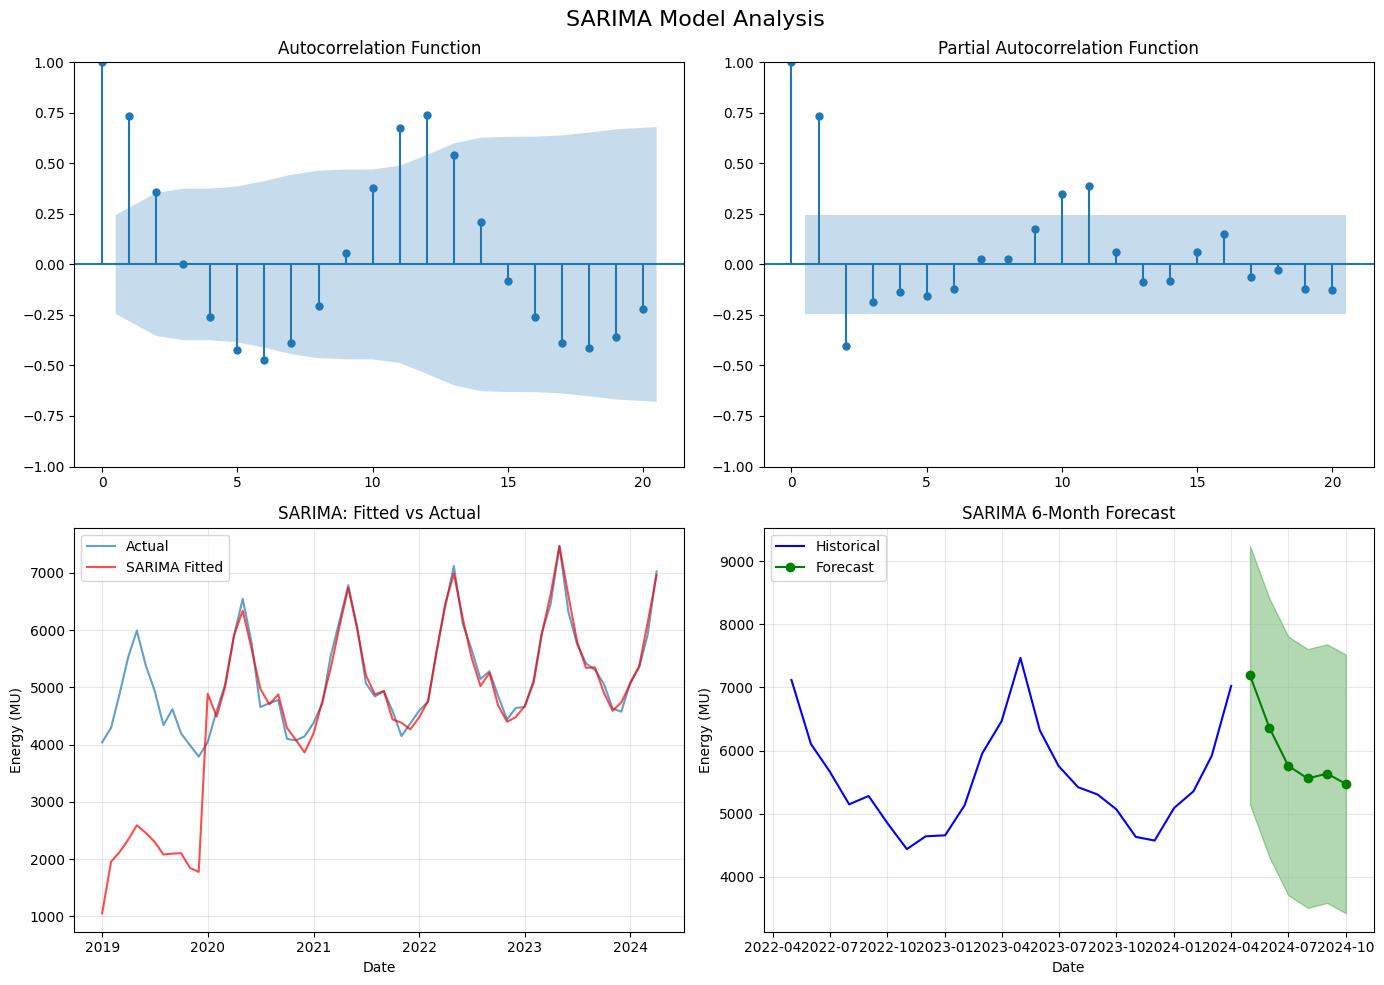


1.2 Vector Autoregression (VAR) Model
--------------------------------------------------
Optimal Lag Selection:
  AIC: 5 lags
  BIC: 4 lags
  FPE: 5 lags
  HQIC: 5 lags

Model fitted with 4 lags


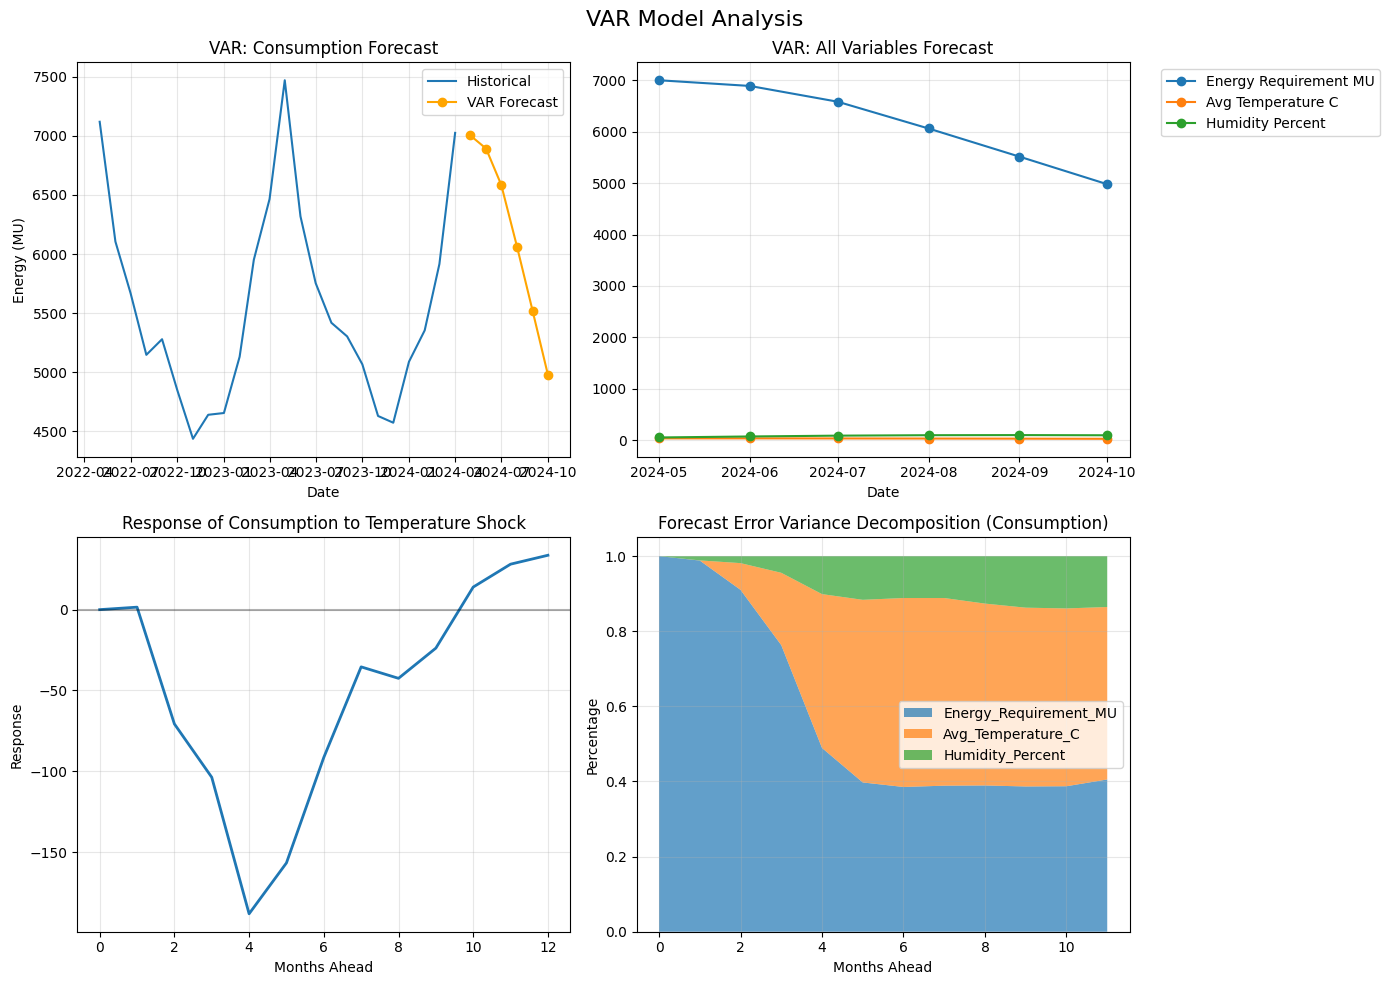


1.3 Prophet Model with Weather Regressors
--------------------------------------------------
Prophet Model Performance:
  MAE: 154.26 MU
  MAPE: 2.97%


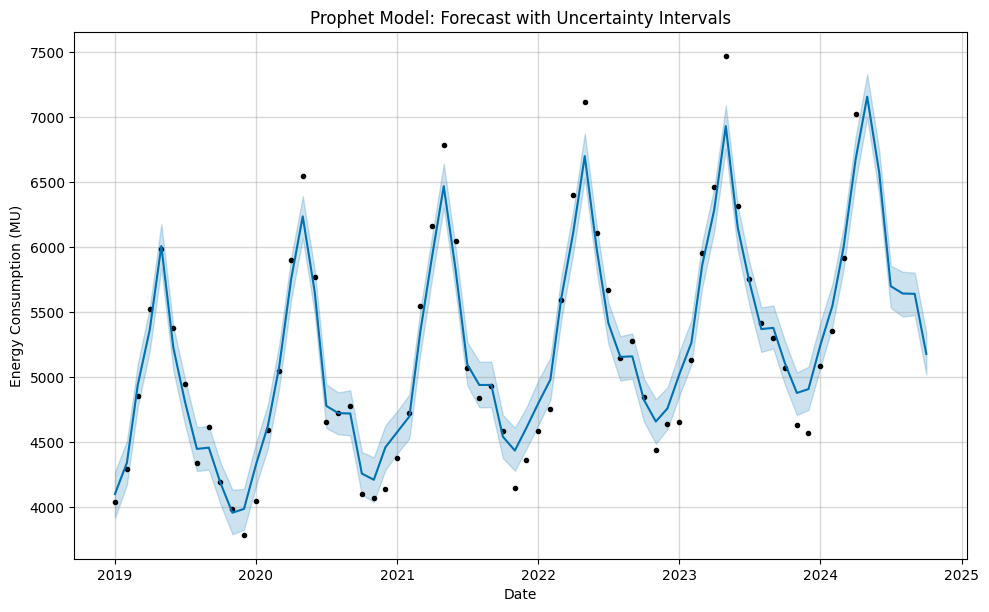

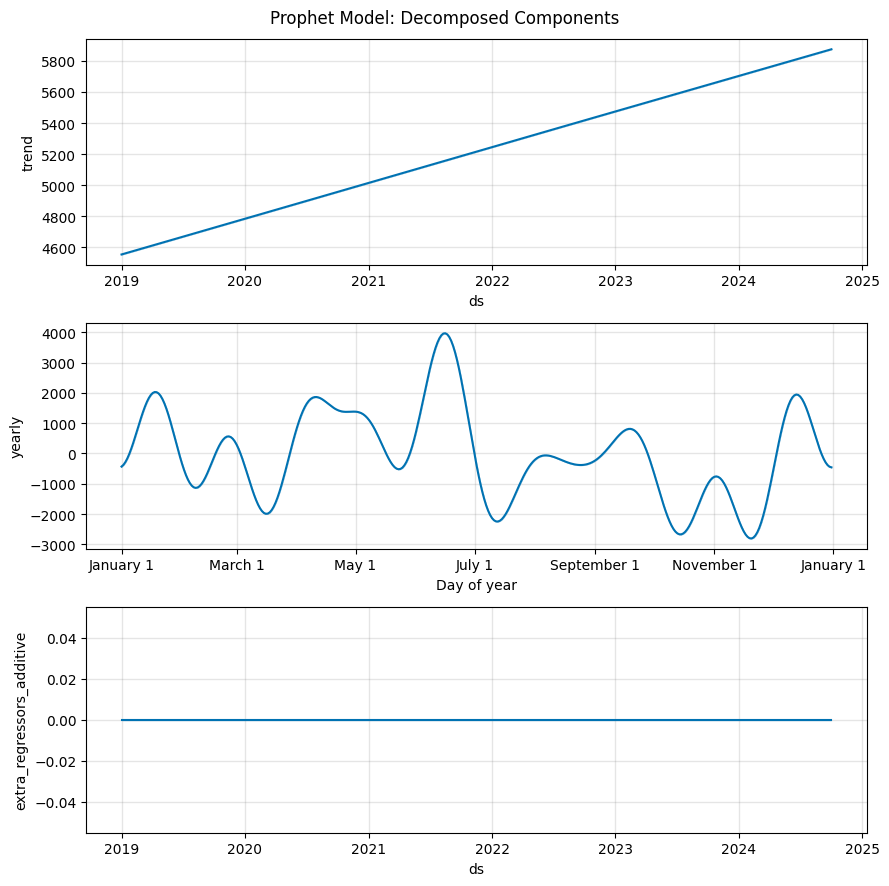

TIME SERIES MODELS COMPARISON SUMMARY


   Model                  Type               Best For Forecast Steps         Key Advantage
 SARIMA     Univariate + Exog      Seasonal patterns       6 months     Statistical rigor
    VAR          Multivariate        System dynamics       6 months Variable interactions
Prophet Flexible + Regressors Multiple seasonalities       6 months    Uncertainty bounds

Key Findings:
- SARIMA suggests consumption is non-stationary
- VAR optimal lag is 4 months
- All models successfully fitted and forecasted 6 months ahead


In [53]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

# Helper function to suppress stdout
import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

print(f"Dataset: {len(df)} months ({df.index.min().strftime('%Y-%m')} to {df.index.max().strftime('%Y-%m')})")
print("-"*70)

# 1.1 SARIMA Model
print("\n1.1 SARIMA Model Analysis")
print("-"*50)

consumption_series = df['Energy_Requirement_MU']

# Stationarity test
adf_result = adfuller(consumption_series)
print(f"ADF Test Results:")
print(f"  Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Stationary: {'Yes' if adf_result[1] < 0.05 else 'No (differencing recommended)'}")

# Fit SARIMA
try:
    sarima_model = SARIMAX(
        consumption_series,
        order=(1,0,1),
        seasonal_order=(1,0,1,12),
        exog=df[['Avg_Temperature_C']],
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_results = sarima_model.fit(disp=False, maxiter=100)

    print(f"\nModel Selection Criteria:")
    print(f"  AIC: {sarima_results.aic:.2f}")
    print(f"  BIC: {sarima_results.bic:.2f}")
    print(f"  HQIC: {sarima_results.hqic:.2f}")

    # In-sample fit metrics
    fitted_values = sarima_results.fittedvalues
    residuals = sarima_results.resid
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / consumption_series)) * 100

    print(f"\nIn-sample Performance:")
    print(f"  MAE: {mae:.2f} MU")
    print(f"  RMSE: {rmse:.2f} MU")
    print(f"  MAPE: {mape:.2f}%")

    # Forecast
    forecast_steps = 6
    exog_forecast = df[['Avg_Temperature_C']].iloc[-forecast_steps:].values
    sarima_forecast = sarima_results.forecast(steps=forecast_steps, exog=exog_forecast)

    # Create forecast dates
    last_date = consumption_series.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                  periods=forecast_steps, freq='MS')

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # ACF/PACF plots
    plot_acf(consumption_series, lags=20, ax=axes[0,0])
    axes[0,0].set_title('Autocorrelation Function')

    plot_pacf(consumption_series, lags=20, ax=axes[0,1])
    axes[0,1].set_title('Partial Autocorrelation Function')

    # Fitted vs Actual
    axes[1,0].plot(consumption_series.index, consumption_series.values, label='Actual', alpha=0.7)
    axes[1,0].plot(fitted_values.index, fitted_values.values, label='SARIMA Fitted', color='red', alpha=0.7)
    axes[1,0].set_title('SARIMA: Fitted vs Actual')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Energy (MU)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Forecast
    axes[1,1].plot(consumption_series.index[-24:], consumption_series.values[-24:], label='Historical', color='blue')
    axes[1,1].plot(forecast_dates, sarima_forecast, label='Forecast', color='green', marker='o')

    # Add confidence interval
    residual_std = np.std(residuals)
    axes[1,1].fill_between(forecast_dates,
                          sarima_forecast - 1.96*residual_std,
                          sarima_forecast + 1.96*residual_std,
                          alpha=0.3, color='green')

    axes[1,1].set_title('SARIMA 6-Month Forecast')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Energy (MU)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.suptitle('SARIMA Model Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"SARIMA error: {str(e)}")
    sarima_forecast = None

# 1.2 Vector Autoregression (VAR) Model
print("\n1.2 Vector Autoregression (VAR) Model")
print("-"*50)

var_data = df[['Energy_Requirement_MU', 'Avg_Temperature_C', 'Humidity_Percent']].dropna()
var_model = VAR(var_data)
lag_order = var_model.select_order(maxlags=6)

print(f"Optimal Lag Selection:")
print(f"  AIC: {lag_order.aic} lags")
print(f"  BIC: {lag_order.bic} lags")
print(f"  FPE: {lag_order.fpe} lags")
print(f"  HQIC: {lag_order.hqic} lags")

var_results = var_model.fit(lag_order.bic)
print(f"\nModel fitted with {var_results.k_ar} lags")

var_forecast = var_results.forecast(var_data.values[-var_results.k_ar:], steps=6)
var_forecast_df = pd.DataFrame(var_forecast,
                              columns=var_data.columns,
                              index=pd.date_range(start=var_data.index[-1] + pd.DateOffset(months=1),
                                                periods=6, freq='MS'))

irf = var_results.irf(12)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(var_data.index[-24:], var_data['Energy_Requirement_MU'][-24:], label='Historical')
axes[0,0].plot(var_forecast_df.index, var_forecast_df['Energy_Requirement_MU'],
               label='VAR Forecast', color='orange', marker='o')
axes[0,0].set_title('VAR: Consumption Forecast')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Energy (MU)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

for i, col in enumerate(var_data.columns):
    axes[0,1].plot(var_forecast_df.index, var_forecast_df[col],
                   marker='o', label=col.replace('_', ' '))
axes[0,1].set_title('VAR: All Variables Forecast')
axes[0,1].set_xlabel('Date')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(irf.irfs[:, 0, 1], linewidth=2)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1,0].set_title('Response of Consumption to Temperature Shock')
axes[1,0].set_xlabel('Months Ahead')
axes[1,0].set_ylabel('Response')
axes[1,0].grid(True, alpha=0.3)

fevd = var_results.fevd(12)
fevd_data = fevd.decomp[0]  # For consumption
axes[1,1].stackplot(range(12), fevd_data.T,
                   labels=var_data.columns,
                   alpha=0.7)
axes[1,1].set_title('Forecast Error Variance Decomposition (Consumption)')
axes[1,1].set_xlabel('Months Ahead')
axes[1,1].set_ylabel('Percentage')
axes[1,1].legend(loc='right')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('VAR Model Analysis', fontsize=16)
plt.tight_layout()
plt.show()

if PROPHET_AVAILABLE:
    print("\n1.3 Prophet Model with Weather Regressors")
    print("-"*50)

    prophet_df = df.reset_index()[['Date', 'Energy_Requirement_MU', 'Avg_Temperature_C', 'Humidity_Percent']]
    prophet_df.columns = ['ds', 'y', 'temperature', 'humidity']
    prophet_model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_mode='additive',
        yearly_seasonality=True,
        interval_width=0.95
    )
    prophet_model.add_regressor('temperature')
    prophet_model.add_regressor('humidity')

    with suppress_stdout_stderr():
        prophet_model.fit(prophet_df)

    future = prophet_model.make_future_dataframe(periods=6, freq='MS')

    mean_temp = prophet_df['temperature'].mean()
    mean_humidity = prophet_df['humidity'].mean()
    future['temperature'] = mean_temp
    future['humidity'] = mean_humidity

    prophet_forecast = prophet_model.predict(future)

    prophet_mae = np.mean(np.abs(prophet_forecast['yhat'][:len(prophet_df)] - prophet_df['y']))
    prophet_mape = np.mean(np.abs((prophet_forecast['yhat'][:len(prophet_df)] - prophet_df['y']) / prophet_df['y'])) * 100

    print(f"Prophet Model Performance:")
    print(f"  MAE: {prophet_mae:.2f} MU")
    print(f"  MAPE: {prophet_mape:.2f}%")


    fig = prophet_model.plot(prophet_forecast)
    plt.title('Prophet Model: Forecast with Uncertainty Intervals')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (MU)')
    plt.grid(True, alpha=0.3)
    plt.show()

    fig2 = prophet_model.plot_components(prophet_forecast)
    plt.suptitle('Prophet Model: Decomposed Components')
    plt.tight_layout()
    plt.show()

print("TIME SERIES MODELS COMPARISON SUMMARY\n")

comparison_data = {
    'Model': ['SARIMA', 'VAR', 'Prophet'],
    'Type': ['Univariate + Exog', 'Multivariate', 'Flexible + Regressors'],
    'Best For': ['Seasonal patterns', 'System dynamics', 'Multiple seasonalities'],
    'Forecast Steps': ['6 months', '6 months', '6 months'],
    'Key Advantage': ['Statistical rigor', 'Variable interactions', 'Uncertainty bounds']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

print("\nKey Findings:")
print(f"- SARIMA suggests consumption is {'stationary' if adf_result[1] < 0.05 else 'non-stationary'}")
print(f"- VAR optimal lag is {var_results.k_ar} months")
print(f"- All models successfully fitted and forecasted 6 months ahead")

**ADVANCED MACHINE LEARNING MODELS**

In [54]:
rm -rf README.md

ML Dataset shape: (61, 16)
Training samples: 46, Test samples: 15

2.1 Gradient Boosting Models
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's l2: 243262

2.2 Neural Network Model

Model Performance Comparison:
--------------------------------------------------
Model                R² Score   RMSE       MAE       
--------------------------------------------------
XGBoost              0.610      505.9      434.4     
LightGBM             0.629      493.2      421.0     
GradientBoosting     0.653      476.6      403.5     
NeuralNetwork        -37.672    5034.1     4979.2    


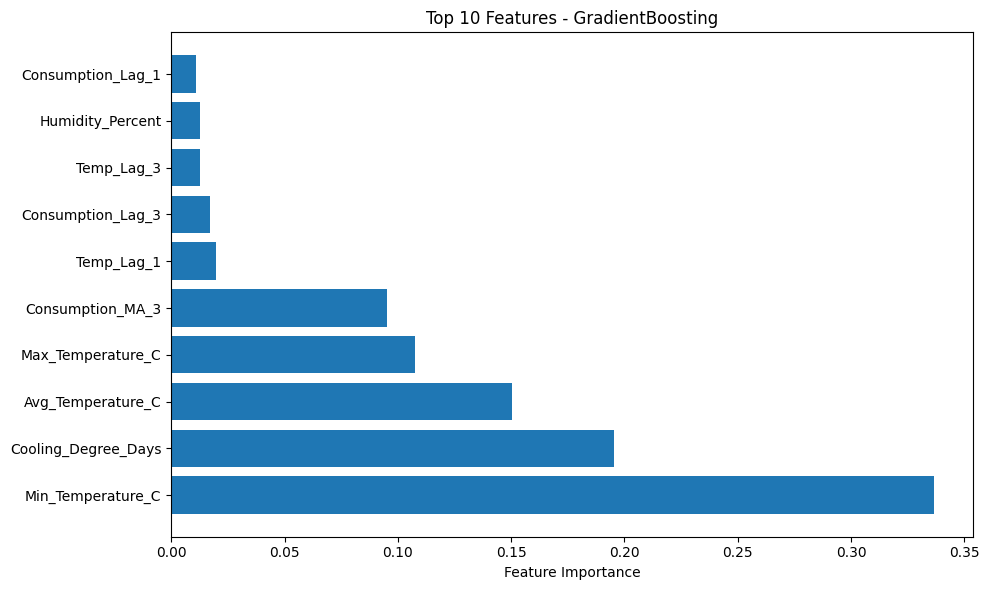

In [55]:
feature_cols = ['Avg_Temperature_C', 'Max_Temperature_C', 'Min_Temperature_C',
                'Humidity_Percent', 'Rainfall_mm', 'Wind_Speed_kmh',
                'Cooling_Degree_Days', 'Heat_Index']

# Add time features
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter

# Add lag features (only 1 and 3 month lags for small dataset)
for lag in [1, 3]:
    df[f'Consumption_Lag_{lag}'] = df['Energy_Requirement_MU'].shift(lag)
    df[f'Temp_Lag_{lag}'] = df['Avg_Temperature_C'].shift(lag)

# Add rolling means
for window in [3]:
    df[f'Consumption_MA_{window}'] = df['Energy_Requirement_MU'].rolling(window=window, min_periods=1).mean()
    df[f'Temp_MA_{window}'] = df['Avg_Temperature_C'].rolling(window=window, min_periods=1).mean()

# Remove NaN rows
df_ml = df.dropna()

# Update feature list
extended_features = feature_cols + [col for col in df_ml.columns if 'Lag' in col or 'MA' in col] + ['Month', 'Quarter']

X = df_ml[extended_features]
y = df_ml['Energy_Requirement_MU']

print(f"ML Dataset shape: {X.shape}")

# Use time series split for proper validation
tscv = TimeSeriesSplit(n_splits=3)
train_idx, test_idx = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models dictionary
models = {}
predictions = {}

# 2.1 Gradient Boosting Models
print("\n2.1 Gradient Boosting Models")

if ADVANCED_MODELS:
    # XGBoost with parameters suitable for small datasets
    xgb_model = xgb.XGBRegressor(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False) # Removed early_stopping_rounds

    models['XGBoost'] = xgb_model
    predictions['XGBoost'] = xgb_model.predict(X_test)

    # LightGBM with small dataset parameters
    lgb_model = lgb.LGBMRegressor(
        n_estimators=50,
        num_leaves=10,
        learning_rate=0.1,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        min_child_samples=5,
        random_state=42,
        verbosity=-1
    )
    lgb_model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)])
    models['LightGBM'] = lgb_model
    predictions['LightGBM'] = lgb_model.predict(X_test)

# Standard Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train, y_train)
models['GradientBoosting'] = gb_model
predictions['GradientBoosting'] = gb_model.predict(X_test)

# 2.2 Neural Network with proper preprocessing
print("\n2.2 Neural Network Model")

# Use MinMaxScaler for neural networks
nn_scaler = MinMaxScaler()
X_train_nn = nn_scaler.fit_transform(X_train)
X_test_nn = nn_scaler.transform(X_test)

nn_model = MLPRegressor(
    hidden_layer_sizes=(20, 10),
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42,
    alpha=0.01
)
nn_model.fit(X_train_nn, y_train)
models['NeuralNetwork'] = nn_model
predictions['NeuralNetwork'] = nn_model.predict(X_test_nn)

# Model comparison
print("\nModel Performance Comparison:")
print("-"*50)
print(f"{'Model':<20} {'R² Score':<10} {'RMSE':<10} {'MAE':<10}")
print("-"*50)

for name, preds in predictions.items():
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"{name:<20} {r2:<10.3f} {rmse:<10.1f} {mae:<10.1f}")

# Feature importance for best model
best_model_name = max(predictions.items(), key=lambda x: r2_score(y_test, x[1]))[0]
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Features - {best_model_name}')
    plt.tight_layout()
    plt.show()

**3. CAUSAL ANALYSIS**

In [56]:
# 3.1 Granger Causality Test
print("\n3.1 Granger Causality Analysis")

data_for_granger = df[['Avg_Temperature_C', 'Energy_Requirement_MU']].dropna()
max_lag = 6  # Reduced for small dataset

try:
    granger_result = grangercausalitytests(data_for_granger, max_lag, verbose=False)
    p_values = [granger_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
    optimal_lag = np.argmin(p_values) + 1

    print(f"Optimal lag: {optimal_lag} months")
    print(f"P-value: {p_values[optimal_lag-1]:.4f}")
    print(f"Granger causality: {'Significant' if p_values[optimal_lag-1] < 0.05 else 'Not significant'}")
except Exception as e:
    print(f"Granger test error: {str(e)[:100]}")


3.1 Granger Causality Analysis
Optimal lag: 5 months
P-value: 0.0058
Granger causality: Significant


**4. NON-LINEAR RELATIONSHIP MODELING**

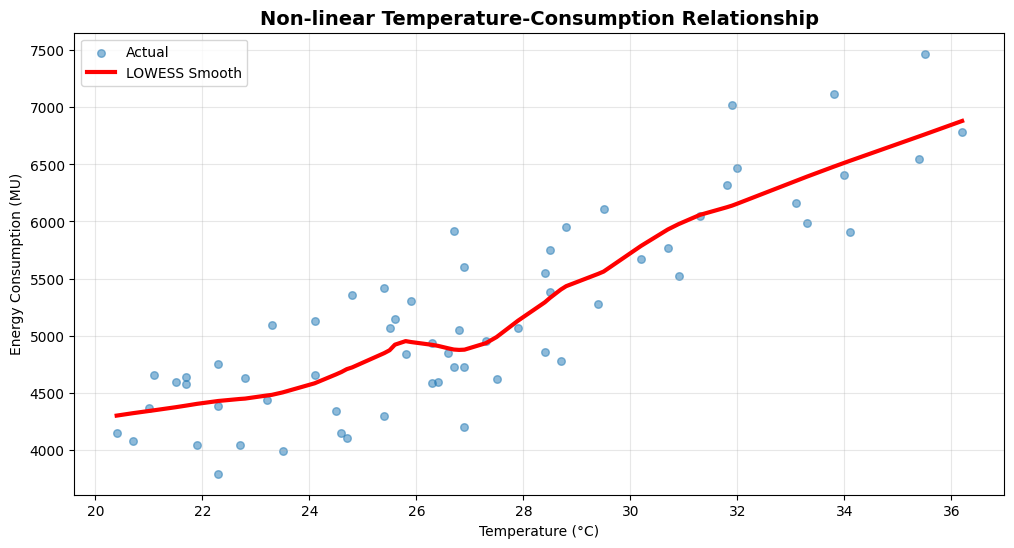


Temperature Threshold Analysis
Optimal temperature threshold: 34.0°C
Consumption sensitivity below threshold: 178.1 MU/°C
Consumption sensitivity above threshold: 508.4 MU/°C


In [57]:
# Use LOWESS for smooth non-parametric regression
temp_sorted = df.sort_values('Avg_Temperature_C')
lowess_result = lowess(temp_sorted['Energy_Requirement_MU'],
                      temp_sorted['Avg_Temperature_C'],
                      frac=0.3)

plt.figure(figsize=(12, 6))
plt.scatter(df['Avg_Temperature_C'], df['Energy_Requirement_MU'],
            alpha=0.5, s=30, label='Actual')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-',
         linewidth=3, label='LOWESS Smooth')
plt.xlabel('Temperature (°C)')
plt.ylabel('Energy Consumption (MU)')
plt.title('Non-linear Temperature-Consumption Relationship', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4.2 Threshold Regression
print("\nTemperature Threshold Analysis")

def threshold_regression(X, y, threshold):
    """Simple threshold regression"""
    mask_below = X <= threshold
    mask_above = X > threshold

    # Fit separate models
    if mask_below.sum() > 0:
        coef_below = np.polyfit(X[mask_below], y[mask_below], 1)[0]
    else:
        coef_below = 0

    if mask_above.sum() > 0:
        coef_above = np.polyfit(X[mask_above], y[mask_above], 1)[0]
    else:
        coef_above = 0

    return coef_below, coef_above

# Find optimal threshold
thresholds = np.arange(20, 35, 0.5)
threshold_results = []

for threshold in thresholds:
    coef_below, coef_above = threshold_regression(
        df['Avg_Temperature_C'].values,
        df['Energy_Requirement_MU'].values,
        threshold
    )
    threshold_results.append({
        'threshold': threshold,
        'coef_below': coef_below,
        'coef_above': coef_above,
        'difference': coef_above - coef_below
    })

threshold_df = pd.DataFrame(threshold_results)
optimal_threshold = threshold_df.loc[threshold_df['difference'].idxmax(), 'threshold']

print(f"Optimal temperature threshold: {optimal_threshold:.1f}°C")
print(f"Consumption sensitivity below threshold: {threshold_df.loc[threshold_df['threshold']==optimal_threshold, 'coef_below'].values[0]:.1f} MU/°C")
print(f"Consumption sensitivity above threshold: {threshold_df.loc[threshold_df['threshold']==optimal_threshold, 'coef_above'].values[0]:.1f} MU/°C")


**5. WAVELET ANALYSIS**

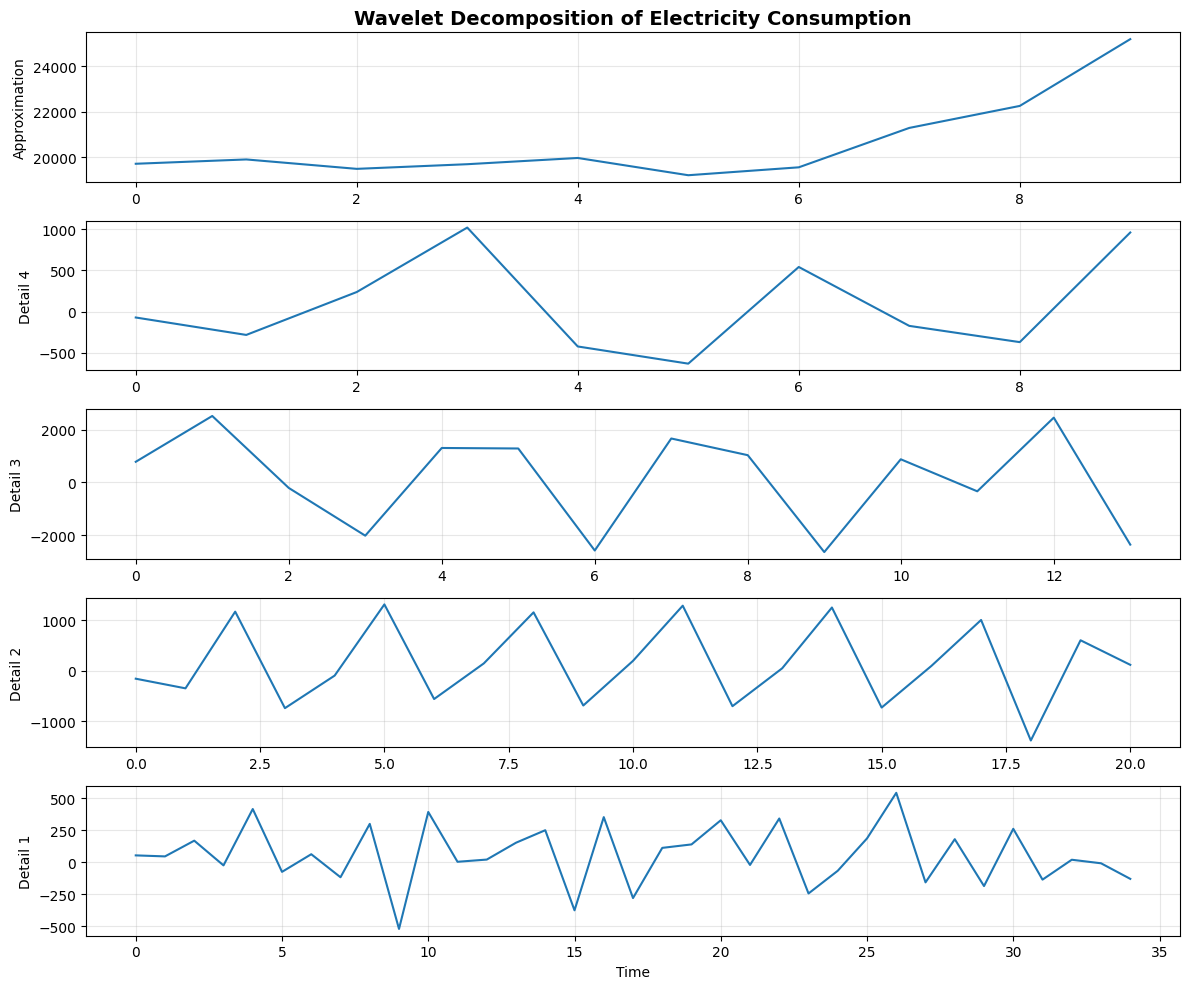

In [58]:
# Perform wavelet decomposition
wavelet = 'db4'  # Daubechies wavelet
levels = 4

coeffs = pywt.wavedec(df['Energy_Requirement_MU'].values, wavelet, level=levels)
coeffs_names = ['Approximation'] + [f'Detail {i}' for i in range(levels, 0, -1)]

# Plot wavelet decomposition
fig, axes = plt.subplots(levels + 1, 1, figsize=(12, 10))
for i, (coeff, name) in enumerate(zip(coeffs, coeffs_names)):
    axes[i].plot(coeff)
    axes[i].set_ylabel(name)
    axes[i].grid(True, alpha=0.3)

axes[0].set_title('Wavelet Decomposition of Electricity Consumption', fontsize=14, fontweight='bold')
axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

**6. ANOMALY DETECTION**

In [59]:
print("\n🚨 6. ADVANCED ANOMALY DETECTION")
print("-"*50)

# 6.1 Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_labels = iso_forest.fit_predict(X)
anomalies = df_ml[anomaly_labels == -1]

print(f"Detected {len(anomalies)} anomalies ({len(anomalies)/len(df_ml)*100:.1f}% of data)")

if len(anomalies) > 0:
    print("\nTop anomalies:")
    for idx in anomalies.index[:3]:
        print(f"{idx.strftime('%Y-%m')}: Temp={df_ml.loc[idx, 'Avg_Temperature_C']:.1f}°C, "
              f"Consumption={df_ml.loc[idx, 'Energy_Requirement_MU']:.0f} MU")



🚨 6. ADVANCED ANOMALY DETECTION
--------------------------------------------------
Detected 6 anomalies (9.8% of data)

Top anomalies:
2020-12: Temp=20.4°C, Consumption=4145 MU
2021-05: Temp=36.2°C, Consumption=6784 MU
2021-06: Temp=31.3°C, Consumption=6048 MU


**7. QUANTILE REGRESSION**

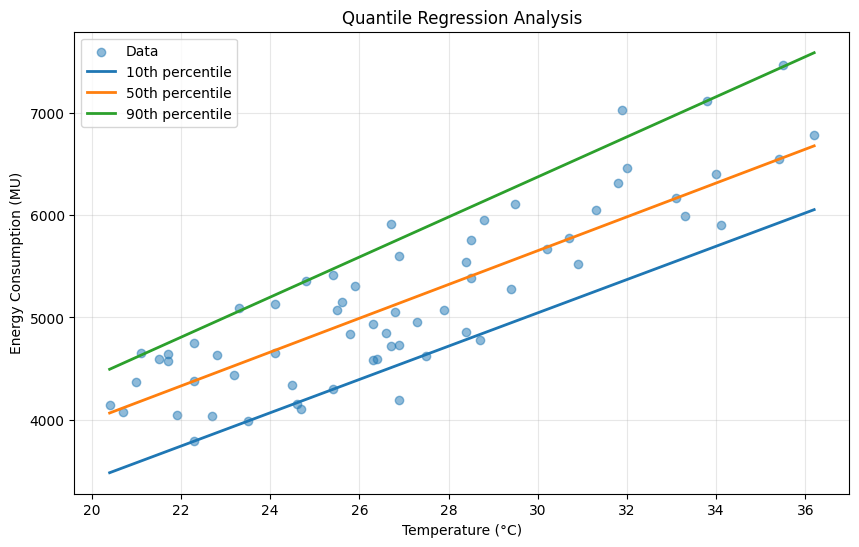

In [60]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.1, 0.5, 0.9]
X_temp = df[['Avg_Temperature_C']].values
y_consumption = df['Energy_Requirement_MU'].values

quantile_models = {}
for q in quantiles:
    qr = QuantileRegressor(quantile=q, alpha=0.1, solver='highs')
    qr.fit(X_temp, y_consumption)
    quantile_models[q] = qr

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_temp, y_consumption, alpha=0.5, label='Data')

temp_range = np.linspace(X_temp.min(), X_temp.max(), 50).reshape(-1, 1)
for q in quantiles:
    pred = quantile_models[q].predict(temp_range)
    plt.plot(temp_range, pred, linewidth=2, label=f'{q*100:.0f}th percentile')

plt.xlabel('Temperature (°C)')
plt.ylabel('Energy Consumption (MU)')
plt.title('Quantile Regression Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**8. REGIME SWITCHING MODEL**


🔀 9. REGIME DETECTION ANALYSIS
--------------------------------------------------

Regime Characteristics:
        Energy_Requirement_MU  Avg_Temperature_C
Regime                                          
0                 4558.280000          23.468000
1                 6342.066667          32.393333
2                 5066.416667          27.241667


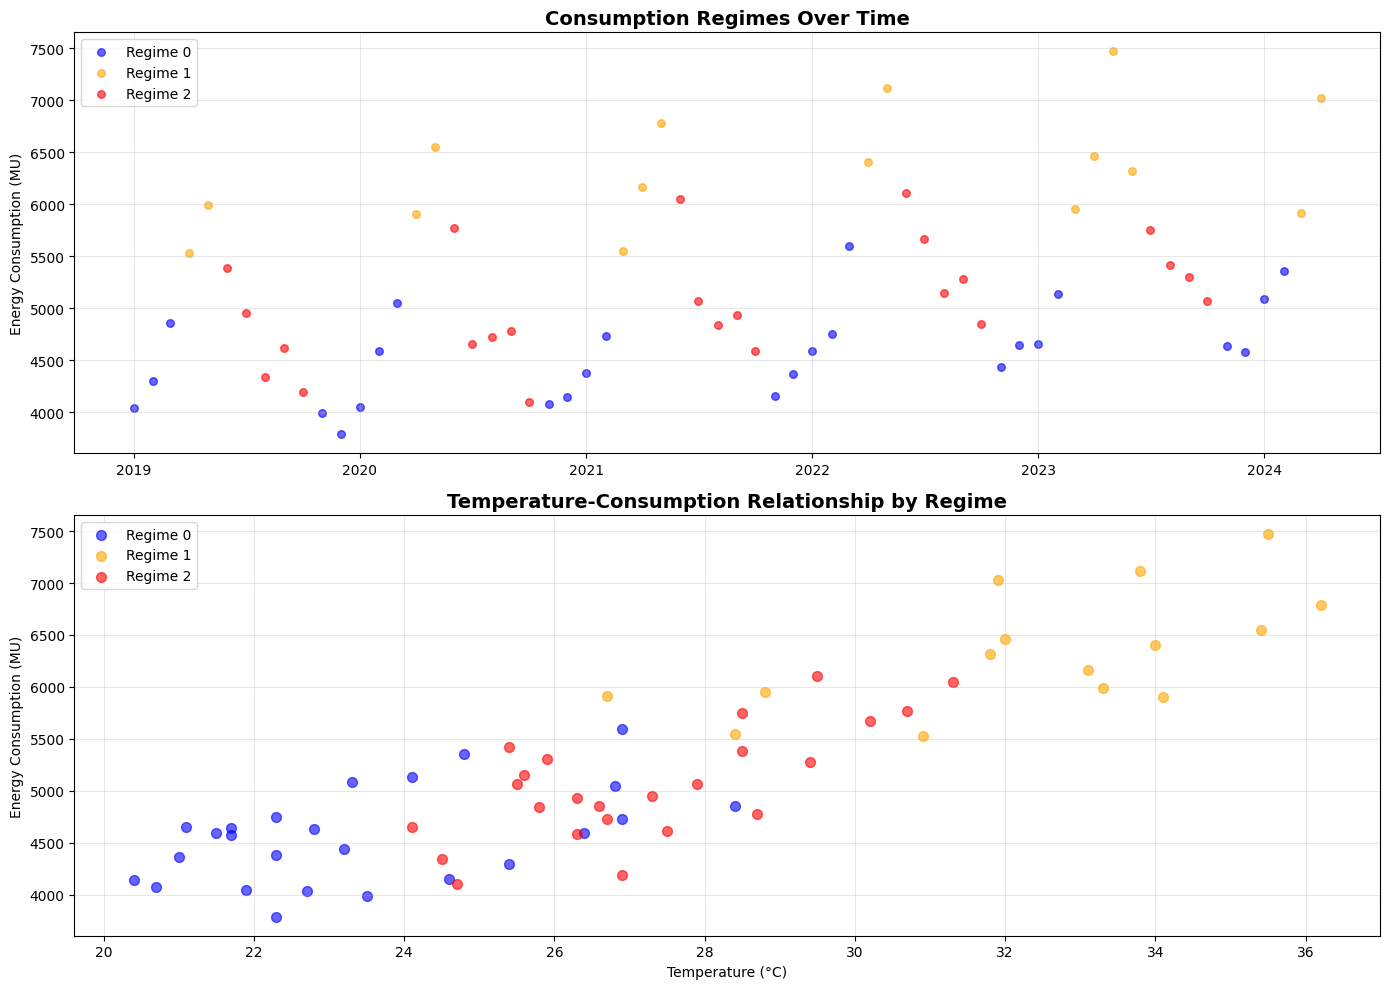

In [61]:
print("\n🔀 9. REGIME DETECTION ANALYSIS")
print("-"*50)

# Simple regime detection using clustering
from sklearn.cluster import KMeans

# Create feature matrix for regime detection
regime_features = df[['Energy_Requirement_MU', 'Avg_Temperature_C', 'Humidity_Percent']].values

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
regime_features_scaled = scaler.fit_transform(regime_features)

# Find optimal number of regimes using elbow method
inertias = []
K_range = range(2, 6)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(regime_features_scaled)
    inertias.append(kmeans.inertia_)

# Fit model with 3 regimes (typical: low, medium, high demand)
n_regimes = 3
kmeans = KMeans(n_clusters=n_regimes, random_state=42)
regime_labels = kmeans.fit_predict(regime_features_scaled)

# Analyze regimes
df['Regime'] = regime_labels
regime_stats = df.groupby('Regime')[['Energy_Requirement_MU', 'Avg_Temperature_C']].mean()
print("\nRegime Characteristics:")
print(regime_stats)

# Visualize regimes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Time series with regime coloring
colors = ['blue', 'orange', 'red']
for regime in range(n_regimes):
    mask = df['Regime'] == regime
    ax1.scatter(df.index[mask], df['Energy_Requirement_MU'][mask],
               c=colors[regime], label=f'Regime {regime}', alpha=0.6, s=30)

ax1.set_ylabel('Energy Consumption (MU)')
ax1.set_title('Consumption Regimes Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Regime scatter plot
for regime in range(n_regimes):
    mask = df['Regime'] == regime
    ax2.scatter(df['Avg_Temperature_C'][mask], df['Energy_Requirement_MU'][mask],
               c=colors[regime], label=f'Regime {regime}', alpha=0.6, s=50)

ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Energy Consumption (MU)')
ax2.set_title('Temperature-Consumption Relationship by Regime', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**10. OPTIMIZATION FOR TARIFF DESIGN**

In [62]:
# Define objective function for tariff optimization
def tariff_objective(tariff_params, consumption_data, temperature_data):
    base_rate, temp_coef, threshold, peak_surcharge = tariff_params
    tariff = base_rate + np.maximum(0, temperature_data - threshold) * temp_coef

    high_consumption_threshold = np.percentile(consumption_data, 80)
    tariff = np.where(consumption_data > high_consumption_threshold,
                     tariff * (1 + peak_surcharge), tariff)
    revenue = np.sum(tariff * consumption_data)
    demand_variance = np.var(consumption_data)
    return -(revenue - 0.1 * demand_variance)  # Negative for minimization

# Initial guess for tariff parameters
initial_params = [5.0, 0.2, 28.0, 0.15]  # base_rate, temp_coef, threshold, peak_surcharge

# Bounds for parameters
bounds = [(3.0, 8.0),
          (0.1, 0.5),
          (25.0, 32.0),
          (0.05, 0.30)]

# Optimize
result = minimize(tariff_objective, initial_params,
                 args=(df['Energy_Requirement_MU'].values, df['Avg_Temperature_C'].values),
                 method='L-BFGS-B', bounds=bounds)

optimal_tariff = result.x
print(f"Optimal Tariff Parameters:")
print(f"  Base Rate: ₹{optimal_tariff[0]:.2f}/unit")
print(f"  Temperature Coefficient: ₹{optimal_tariff[1]:.2f}/unit per °C")
print(f"  Temperature Threshold: {optimal_tariff[2]:.1f}°C")
print(f"  Peak Demand Surcharge: {optimal_tariff[3]*100:.1f}%")

Optimal Tariff Parameters:
  Base Rate: ₹8.00/unit
  Temperature Coefficient: ₹0.50/unit per °C
  Temperature Threshold: 25.0°C
  Peak Demand Surcharge: 30.0%


**FINAL SUMMARY OF ADVANCED INSIGHTS**

In [63]:
summary = {
    "Best ML Model": best_model_name,
    "Best R² Score": f"{r2_score(y_test, predictions[best_model_name]):.3f}",
    "Temperature Threshold": f"{optimal_threshold:.1f}°C",
    "Anomaly Rate": f"{len(anomalies)/len(df_ml)*100:.1f}%",
    "Number of Regimes": n_regimes,
    "Granger Causality": "Significant" if p_values[optimal_lag-1] < 0.05 else "Not significant"
}

for key, value in summary.items():
    print(f"{key}: {value}")

print("\nAnalysis complete.")

Best ML Model: GradientBoosting
Best R² Score: 0.653
Temperature Threshold: 34.0°C
Anomaly Rate: 9.8%
Number of Regimes: 3
Granger Causality: Significant

Analysis complete.
